In [1]:
# Importing the Necessary Libraries
from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image as Img, display 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
from PIL import Image, ImageOps

In [2]:
# Connecting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Loading the Saved Model
network = load_model('/content/drive/MyDrive/Papers/Pneumonia_CAD/Primary Material/Results/Pneumonia_Paper/ChestVGG_SGD.h5')

In [10]:
model = tf.keras.models.Model(inputs=network.input, outputs=network.output)

In [5]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [6]:
img = keras.preprocessing.image.load_img('/content/person390_bacteria_1781.jpeg', target_size=(224, 224))

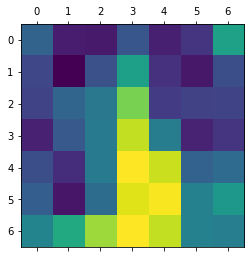

In [11]:
# Generate class activation heatmap
def img_array(image_data):

        # Preparing the Image
        size = (224,224)    
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img=img/255.      
        img_reshape = img[np.newaxis,...]

        # Extracting Features of the Image for Predicting Using KNN Classifier
        # Making the Prediction Using KNN Classifier

        return img_reshape
#model.layers[-1].activation = None
img_array=img_array(img)
heatmap = make_gradcam_heatmap(img_array, model,'concatenate_11')

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [8]:
img_path='/content/person390_bacteria_1781.jpeg'

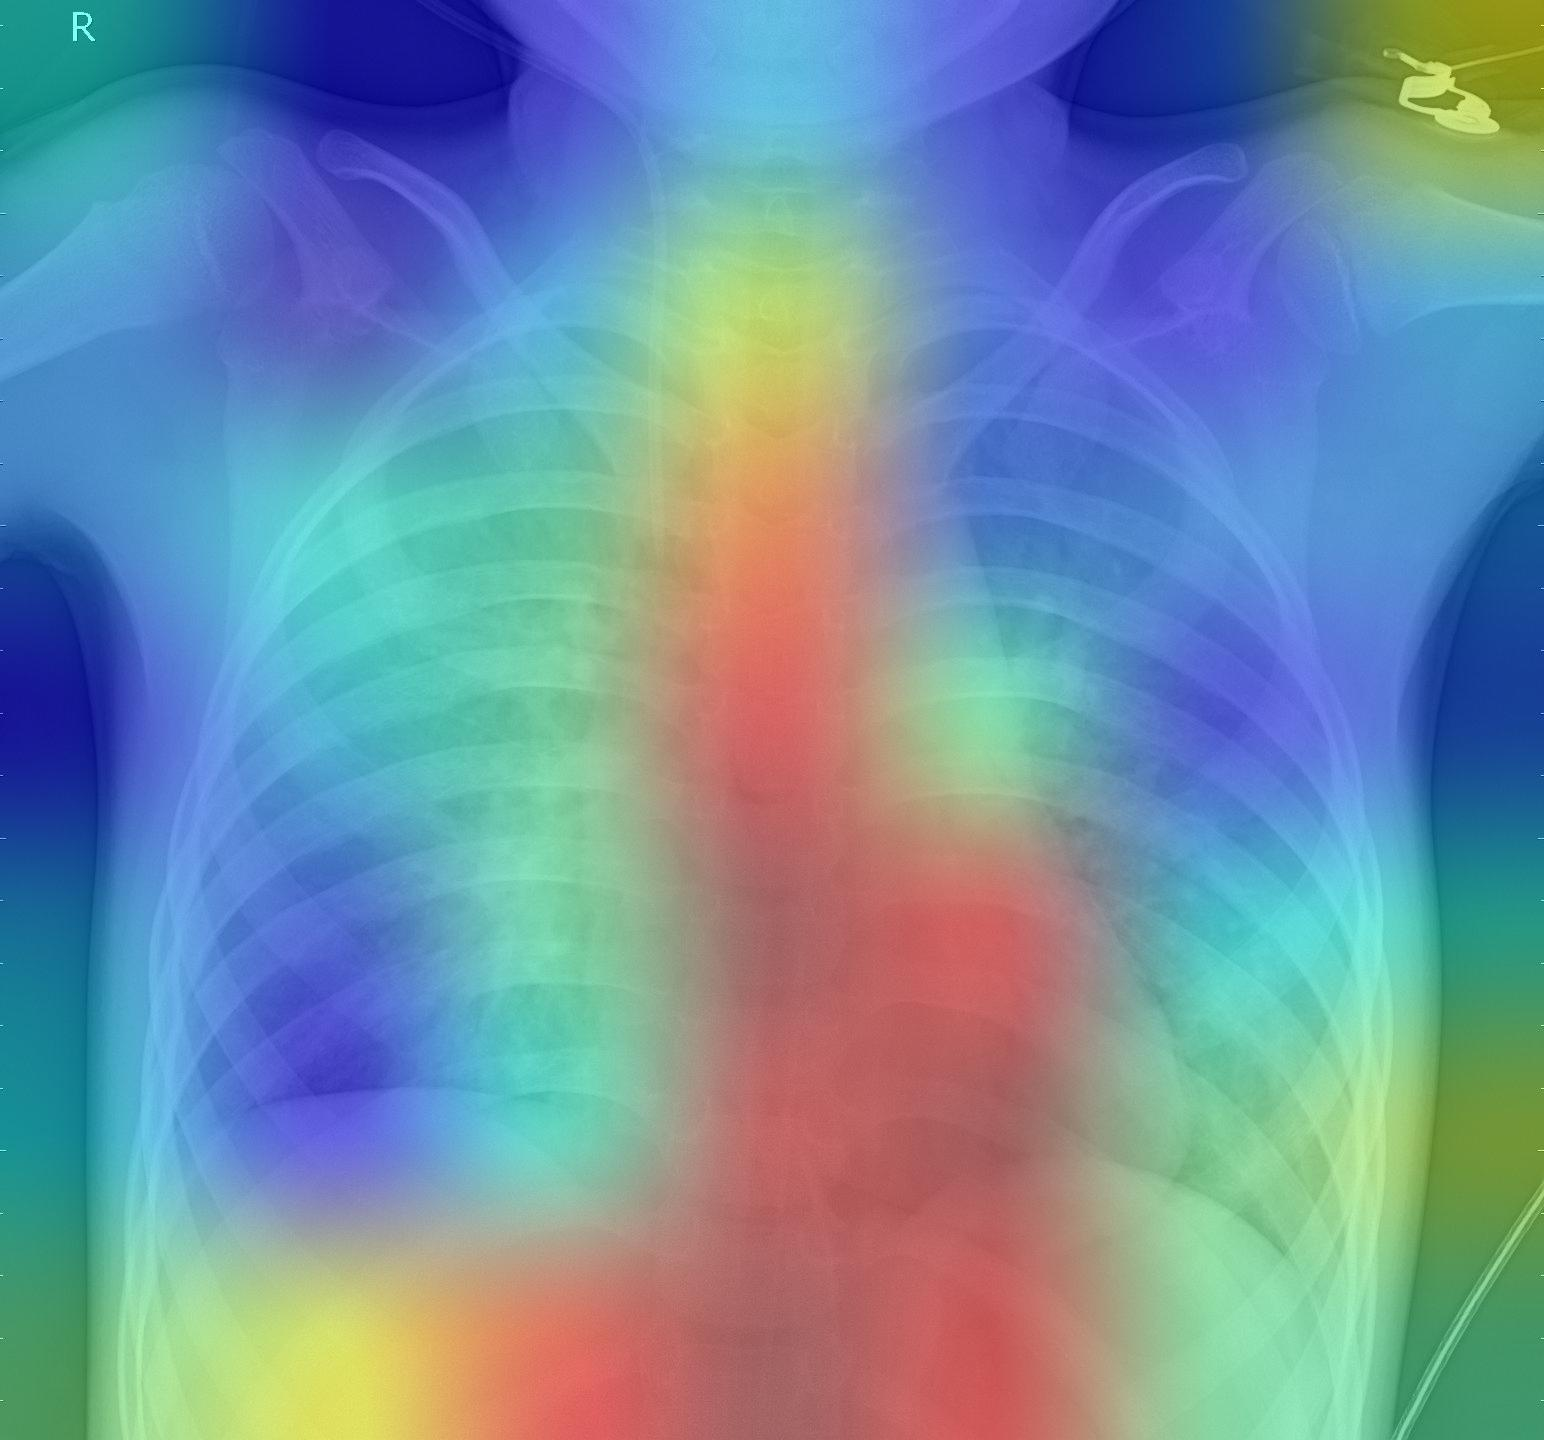

In [12]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=1):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Img(cam_path))


save_and_display_gradcam(img_path, heatmap)

In [72]:
img = keras.preprocessing.image.load_img('/content/covid.png', target_size=(224, 224))

In [73]:
def import_and_predict(image_data, feature_extractor):

        # Preparing the Image
        size = (224,224)    
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img=img/255.      
        img_reshape = img[np.newaxis,...]

        # Extracting Features of the Image for Predicting Using KNN Classifier
        features_for_knn=feature_extractor.predict(img_reshape)
        pred=np.argmax(features_for_knn)

        return pred

In [74]:
import_and_predict(img, model)

0